# MgO Analysis Manual Scans

We start with manual scans from MgO 1800 nm short pulses

In [1]:
## necessary import statements
from HARP.scan_anal import Scan
from HARP.iris_functions import Iris
from HARP.image_processing import Image
import os
from scipy.optimize import curve_fit
from scipy.signal import find_peaks, savgol_filter, peak_widths
import numpy as np 
import matplotlib.pyplot as plt
from functions import Andor_calib
from functions import Adams_wedge_thickness, gaus
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

In [2]:
from matplotlib import rc
rc('font',size=22)

In [3]:
#Iris calibration from 28th Jan at 1800 nm short pulse
""" 1800 nm scans"""
power_3101_1800short = np.array([235, 235, 235, 235, 235, 235, 230, 225, 225, 220, 205, 195, 170, 130, 100, 65, 30, 9, 3])*1e-3
iris_pos_3101_1800short = np.linspace(45,-45,19)

iris_3101 = Iris()
iris_3101.specify_calib(iris_positions=iris_pos_3101_1800short, powers=power_3101_1800short)
iris_3101.specify_params(w0_init=100e-6, f=0.75, wl=1800e-9, M2=1, reprate=1000,pulse_duration=15e-15)


In [4]:
data_folder = '/Volumes/qolslc/20120009 - Matthews' 
data_folder = os.path.join(data_folder,'2022-01-31')
os.listdir(data_folder)

['._.DS_Store',
 'Chirp scan_manual',
 'Rotation scan_manual',
 'DynoimagesMgO',
 '.DS_Store',
 'HCF spectra']

In [5]:
Chirp_folder = os.path.join('/Users/kasia/Documents/Data/Artemis22/2022-01-31','Chirp scan_manual')
Rotation_folder = os.path.join(data_folder, 'Rotation scan_manual')

# Chirp Scan Analysis

Manual Scans but this is the data we have from the MgO

In [6]:
Chirp = Scan()
Chirp.set_folder(Chirp_folder)
Chirp.set_verlim(1070, 1090)
files = [i for i in os.listdir(Chirp_folder) if 'sig' in i]
bg = []
exclude = bg+[]
files = [i for i in files if i not in exclude]
files

['min26.5_step1500_sig_X1.tif',
 'min26.5_step4000_sig_X1.tif',
 'min26.5_step2250_sig_X1.tif',
 'min26.5_step3750_sig_X1.tif',
 'min26.5_step2500_sig_X1.tif',
 'min26.5_step1250_sig_X1.tif',
 'min26.5_step3000_sig_X1.tif',
 'min26.5_step1750_sig_X1.tif',
 'min26.5_step2000_sig_X1.tif',
 'min26.5_step3500_sig_X1.tif',
 'min26.5_step2750_sig_X1.tif',
 'min26.5_step1000_sig_X1.tif',
 'min26.5_step3250_sig_X1.tif']

In [7]:
variables = [float(i.split('_')[1][4:]) for i in files]
Chirp.set_params(rotation=0, MCPPos=120000,iris=-26.5)
Chirp.set_eVlim((12,26))
stage = 'wedge'
variables


[1500.0,
 4000.0,
 2250.0,
 3750.0,
 2500.0,
 1250.0,
 3000.0,
 1750.0,
 2000.0,
 3500.0,
 2750.0,
 1000.0,
 3250.0]

In [13]:
Chirp.populate_scan_manual(files, variables, stage=stage, function = Andor_calib)
Chirp.add_calibration_stage('intensity', iris_3101.get_intensity_TWcm2, 'iris')
Chirp.add_calibration_stage('thick', Adams_wedge_thickness, 'wedge')
Chirp.scan_data.head()
#Chirp.substract_bg(byitself=True, bg_lim=[0,0,10,10])

100%|██████████| 13/13 [00:09<00:00,  1.38it/s]


,Data,iris,wedge,rotation,MCP Pos,intensity,thick
0,<trace_anal.HarmonicTrace object at 0x7fcfdf8b...,-26.5,1500.0,0,120000,12.72,0.68
1,<trace_anal.HarmonicTrace object at 0x7fcfdf84...,-26.5,4000.0,0,120000,12.72,1.49
2,<trace_anal.HarmonicTrace object at 0x7fcfdf81...,-26.5,2250.0,0,120000,12.72,0.92
3,<trace_anal.HarmonicTrace object at 0x7fcfdf81...,-26.5,3750.0,0,120000,12.72,1.40
4,<trace_anal.HarmonicTrace object at 0x7fcfdc38...,-26.5,2500.0,0,120000,12.72,1.00


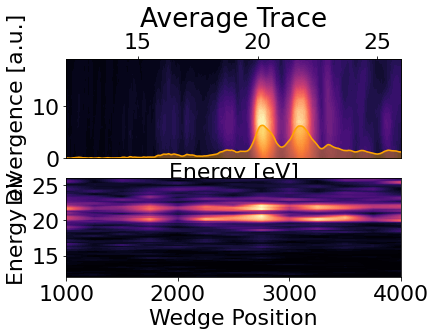

In [14]:
fig, ax = plt.subplots(2)
im, ax[0], ax2 = Chirp.plot_average(ax[0])
ax[0].set_title('Average Trace')
ax[0].xaxis.tick_top()
ax[0].set_xlabel('Energy [eV]', va = 'top')
ax[0].set_ylabel('Divergence [a.u.]')
im, ax[1] = Chirp.plot_scan_mean(ax[1], stage)
ax[1].set_xlabel('Wedge Position')
ax[1].set_ylabel('Energy eV')
plt.show()

So from the average intensity scan we can only see the plasmon. We can see that the plasmon starts at around 12 TW/cm2. So we need to mask it at around 28 iris position. The plasmon analysis should be done at some point too. 

The scatter seams constant throughout the Intensity scan so we can try to filter it out for out lineoutss - We need to check this is the same for all iris plots and all  samples and days!

[0.52 0.6  0.68 0.76 0.84 0.92 1.   1.08 1.16 1.24 1.32 1.4  1.49]


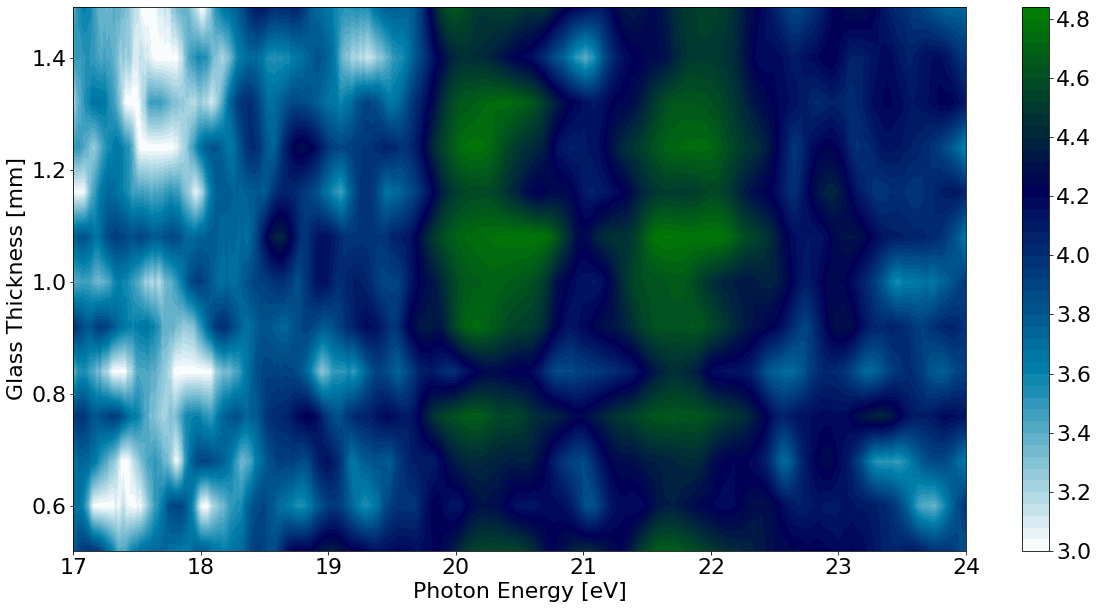

In [19]:
x, y, Z = Chirp.return_scan_data('thick')
fig, ax = plt.subplots(figsize = (20,10))
vmin=10**3
Z[Z<vmin]=vmin
cma = ax.contourf(y,x,np.log10(Z), levels=50, cmap='ocean_r')
cba = plt.colorbar(cma, ax=ax)
ax.set_ylabel('Glass Thickness [mm]')
ax.set_xlabel('Photon Energy [eV]')
ax.set_xlim(17,24)
print(x)

(17.0, 24.0)

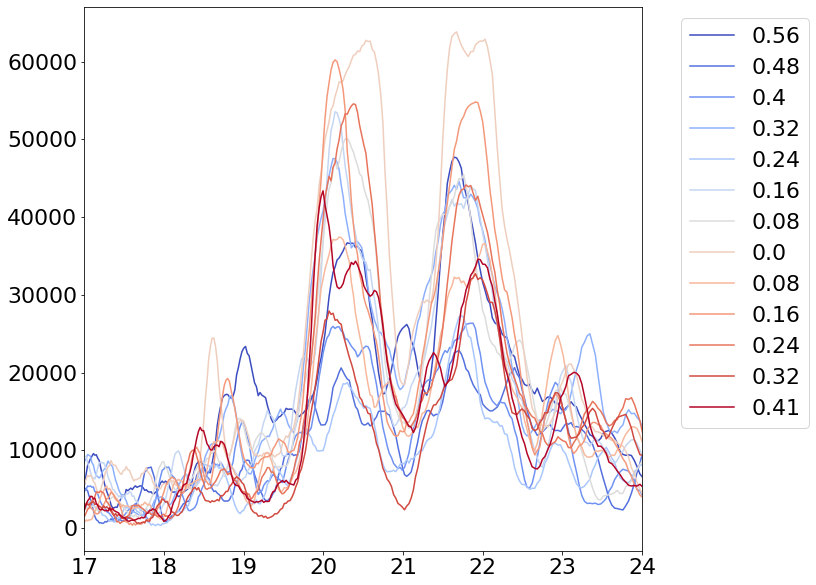

In [20]:
x, y, Z = Chirp.return_scan_data('thick')
cmap = plt.get_cmap('coolwarm')
colors = [cmap(i) for i in np.linspace(0, 1, len(x))]
vmin=10**2.4
Z[Z<vmin]=vmin
plt.figure(figsize=(10,10))
for i in range(len(x)):
    plt.plot(y,Z[i], label=abs(x[i]-1.08).round(2),color=colors[i])

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlim(17,24)

In [12]:
x, y, Z = Chirp.return_scan_data('thick')
cmap = plt.get_cmap('coolwarm')
colors = [cmap(i) for i in np.linspace(0, 1, len(x))]
vmin=10**2.4
Z[Z<vmin]=vmin
plt.figure(figsize=(10,10))
mask = x <= 1.08
for i in range(len(x[mask])):
    plt.plot(y,Z[mask][i], label=abs(x[mask][i]-1.08).round(2),color=colors[mask][i])

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlim(17,25)

TypeError: only integer scalar arrays can be converted to a scalar index

<Figure size 720x720 with 0 Axes>

[]

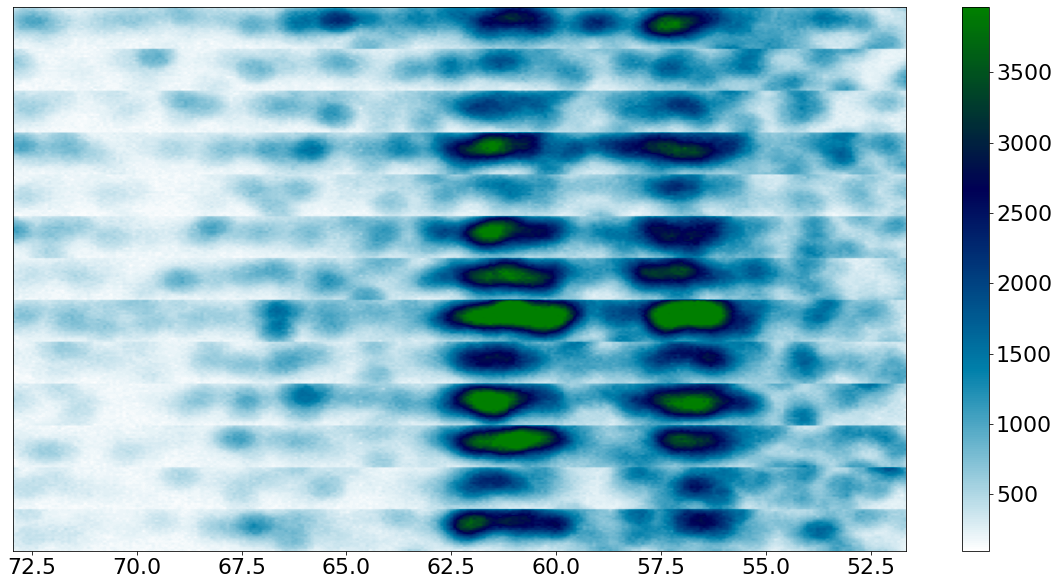

In [21]:
x, y, Z = Chirp.return_scan_data_slab('thick')
fig, ax = plt.subplots(figsize = (20,10))
#cma = ax.contourf(y,x,np.log10(Z), levels=50, cmap='ocean_r')
cma = ax.imshow(Z, cmap='ocean_r', extent=[max(y), min(y), -1,1], aspect='auto')
cba = plt.colorbar(cma, ax=ax)
ax.set_xlim(1240/17, 1240/24)
ax.set_yticks([])


# Rotation Scan Analysis

Manual Scans but this is the data we have from the MgO

In [ ]:
Rot = Scan()
Rot.set_folder(Rotation_folder)
Rot.set_verlim(1060, 1100)
files = [i for i in os.listdir(Rotation_folder) if 'sig' in i]
bg = []
exclude = bg+[]
files = [i for i in files if i not in exclude]
print(files)

In [ ]:
variables = [float(i.split('_')[1][:-3]) for i in files]
Rot.set_params(wedge=1060, MCPPos=120000,iris=-26.5)
Rot.set_eVlim((12,27))
stage = 'rotation'
print(variables)

In [ ]:
Rot.populate_scan_manual(files, variables, stage=stage, function = Andor_calib)
Rot.add_calibration_stage('intensity', iris_3101.get_intensity_TWcm2, 'iris')
Rot.substract_bg(byitself=True, bg_lim=[0,0,10,10])
Rot.sort_by_stage(stage)

In [ ]:
fig, ax = plt.subplots(2)
im, ax[0], ax2 = Rot.plot_average(ax[0])
ax[0].set_title('Average Trace')
ax[0].xaxis.tick_top()
ax[0].set_xlabel('Energy [eV]', va = 'top')
ax[0].set_ylabel('Divergence [a.u.]')
im, ax[1] = Rot.plot_scan_mean(ax[1], stage)
ax[1].set_xlabel('Rotation')
ax[1].set_ylabel('Energy eV')
plt.show()

So from the average intensity scan we can only see the plasmon. We can see that the plasmon starts at around 12 TW/cm2. So we need to mask it at around 28 iris position. The plasmon analysis should be done at some point too. 

The scatter seams constant throughout the Intensity scan so we can try to filter it out for out lineoutss - We need to check this is the same for all iris plots and all  samples and days!

In [ ]:

x, y, Z = Rot.return_scan_data('rotation')
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(20,10))
r,theta = np.meshgrid(y,np.radians(x))
vmin = 10000
Z[Z<vmin]=vmin
pc = ax.contourf(theta, r, Z, levels=50, cmap='Greys_r')
ax.set_thetalim(np.radians(min(x)), np.radians(max(x)))
ax.set_rlim(19,26)
cbc = plt.colorbar(pc, ax=ax)



# Checking intensity Scans

In [ ]:
Iris_Folder = os.path.join('../../../Data/2022-01-28/','Iris_scan_SampleX-10_Y-5.25_Z9.0_rot_2_MgO_SWIR_MCP1200V_scanningUp_MCPpos100')
MCP100_Iris = Scan()
MCP100_Iris.set_folder(Iris_Folder)
MCP100_Iris.set_verlim(150, 250)
files = [i for i in os.listdir(Iris_Folder)]
bg = ['-45_repeat2.tif','-45_repeat.tif']
exclude = bg+['-28.5.tif','-22_repeat.tif','-28.5_repeat.tif', '-28.5_repeat2.tif','-24.5_repeat.tif','-22_mightbe22.5.tif' ]
files = [i for i in files if i not in exclude]
variables = [float(i[:-4]) for i in files]
MCP100_Iris.set_params(rotation=0, MCPPos=100000,wedge=1060)
MCP100_Iris.set_eVlim((17,26))
stage = 'iris'


In [ ]:
#Iris calibration from 28th Jan at 1800 nm short pulse
""" 1800 nm scans"""
power_2801_1800short = np.array([184, 180, 180,180,180,180,176, 180,180,165,162,150,130,110,86,58,31,11.5,4])*1e-3
iris_pos_2801_1800short = np.linspace(45,-45,19)

iris_2801 = Iris()
iris_2801.specify_calib(iris_positions=iris_pos_2801_1800short, powers=power_2801_1800short)
iris_2801.specify_params(w0_init=100e-6, f=0.75, wl=1800e-9, M2=1, reprate=1000,pulse_duration=15e-15)


In [ ]:
MCP100_Iris.populate_scan_manual(files, variables, stage='iris', function = Andor_calib)
MCP100_Iris.add_calibration_stage('intensity', iris_2801.get_intensity_TWcm2, 'iris')
stage = 'intensity'
MCP100_Iris.sort_by_stage(stage)
MCP100_Iris.add_background_from_scan(-45)
MCP100_Iris.substract_bg()

In [ ]:
fig, ax = plt.subplots(2)
im, ax[0], ax2 = MCP100_Iris.plot_average(ax[0])
ax[0].set_title('Average Trace')
ax[0].xaxis.tick_top()
ax[0].set_xlabel('Energy [eV]', va = 'top')
ax[0].set_ylabel('Divergence [a.u.]')
im, ax[1] = MCP100_Iris.plot_scan_mean(ax[1], 'intensity')
ax[1].set_xlabel('Intensity [TW/cm2]')
ax[1].set_ylabel('Energy eV')
plt.show()

In [ ]:

x, y, Z = MCP100_Iris.return_scan_data('intensity')
fig, ax = plt.subplots(figsize = (20,10))
vmin = 1e2
Z[Z<vmin]=vmin
cma = ax.contourf(y,x,np.log10(Z), levels=50, cmap='Greys_r')
cba = plt.colorbar(cma, ax=ax)
plt.xlabel('Photon Energy [eV]')
plt.ylabel('Intensity [TW/cm2]')

In [ ]:
t1 = Chirp.scan_data[Chirp.scan_data['wedge']==1000]
t2 = MCP100_Iris.scan_data[MCP100_Iris.scan_data['intensity']==12.29]
t3 = MCP100_Iris.scan_data[MCP100_Iris.scan_data['intensity']==13.2]
t4 = MCP100_Iris.scan_data[MCP100_Iris.scan_data['intensity']==14.14]
t5 = MCP100_Iris.scan_data[MCP100_Iris.scan_data['intensity']==11.42]
t6 = MCP100_Iris.scan_data[MCP100_Iris.scan_data['intensity']==10.58]

In [ ]:
MCP100_Iris.scan_data['intensity']


In [ ]:
plt.figure(figsize=(20,10))
for t in [t2,t1, t3]:
    trace = t['Data'].values[0]
    lo = trace.data.sum(axis=0)
    peaks, bob = find_peaks(lo, distance=40, height = 0.3*max(lo))
    norm = lo[peaks[np.argmin(np.abs(22-trace.eV_axis[peaks]))]]
    print(norm)
    plt.plot(trace.eV_axis, lo/norm,lw=3)
    #for p in peaks:
    #    plt.annotate(np.round(trace.eV_axis[p],2), (trace.eV_axis[p], lo[p]/norm), fontsize=15)
    print(np.diff(trace.eV_axis[peaks]))

plt.legend(['12.3 TW/cm2','12.7 TW/cm2','13.2 TW/cm2'])
plt.xlim(15,26)

In [ ]:
peak_info = []
for i in MCP100_Iris.scan_data['intensity'].to_numpy()[10:]:
    t = MCP100_Iris.scan_data[MCP100_Iris.scan_data['intensity']==i]
    trace = t['Data'].values[0]
    lo = trace.data.sum(axis=0)
    lo = savgol_filter(lo, 11,3)
    peaks, bob = find_peaks(lo, distance=20)
    for k in range(len(peaks)):
        peak_info.append((trace.eV_axis[peaks][k], lo[peaks][k], peak_widths(lo, peaks)[0][k], i))
    #peak_info.append(zip(trace.eV_axis[peaks], lo[peaks], peak_widths(lo, peaks)[0]))
    plt.plot(trace.eV_axis, lo, lw=3, label = i)
    plt.plot(trace.eV_axis[peaks], lo[peaks], 'o')

#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.xlim(19.5,22)
plt.ylim(0, 0.02e6)

In [ ]:

har_17 = np.array([i for i in peak_info if i[0]<18])
har_18 = np.array([i for i in peak_info if i[0]<18.5 and i[0]>18])
har_19 = np.array([i for i in peak_info if i[0]>18.5 and i[0]<19.5])
har_20 = np.array([i for i in peak_info if i[0]<21 and i[0]>19.5])
har_21 = np.array([i for i in peak_info if i[0]>21 and i[0]<22])
har_22 = np.array([i for i in peak_info if i[0]>22])

list_of_harmonics = [har_17, har_18, har_19, har_20,har_21, har_22]
fig, ax = plt.subplots(1,len(list_of_harmonics), sharey=True, figsize=(20,5))
fig2, ax2 = plt.subplots()
count=0
for idx in range(len(list_of_harmonics)):
    ax[idx].hist(list_of_harmonics[idx][:,0])
    bw = max(list_of_harmonics[idx][:,0])-min(list_of_harmonics[idx][:,0])
    ax2.plot(count, bw, 'x')
    count+=1



In [ ]:

for idx in range(len(list_of_harmonics[3:])):
    har = list_of_harmonics[3:][idx]
    plt.semilogy(har[:,3], har[:,1], label = np.round(har[0][0],1))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Intensity [TW/cm2]')
plt.ylabel('Log Scale of peak height')



In [ ]:
for idx in range(len(list_of_harmonics[3:])):
    har = list_of_harmonics[3:][idx]
    plt.plot(har[:,3], har[:,2], label = np.round(har[0][0],1))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Intensity [TW/cm2]')
plt.ylabel('Width [pix]')

In [ ]:
eV = np.linspace(0.4, 1, 20)
fund = gaus(eV, 1, 1240/1800, (1240/1700 - 1240/2000))

long_eV = []
har = []
for i in [25,27,29,31]:
    new_eV = eV*i
    long_eV.append(new_eV)
    har.append(gaus(new_eV, 1, i*(1240/1800), i*(1240/1790 - 1240/1810)))
long_eV = [item for sublist in long_eV for item in sublist]
har = [item for sublist in har for item in sublist]
plt.plot(long_eV, har)

## Spectrum Comparison

In [ ]:
data =  [243.40222 ,203.53461 ,272.77835 ,258.09029 ,274.87665 ,265.43432 ,265.43432 ,305.30192 ,274.87665 ,248.64796 ,228.71415 ,328.38317 ,267.53261 ,280.12238 ,245.50052 ,297.95789 ,271.72920 ,278.02409 ,219.27183 ,310.54766 ,281.17153 ,287.46642 ,236.05819 ,266.48347 ,228.71415 ,278.02409 ,254.94284 ,278.02409 ,243.40222 ,198.28888 ,273.82750 ,272.77835 ,258.09029 ,258.09029 ,289.56471 ,211.92779 ,317.89169 ,236.05819 ,252.84455 ,293.76130 ,230.81245 ,270.68006 ,260.18858 ,252.84455 ,227.66501 ,250.74625 ,278.02409 ,230.81245 ,248.64796 ,232.91075 ,249.69711 ,285.36812 ,249.69711 ,261.23773 ,278.02409 ,266.48347 ,285.36812 ,316.84255 ,190.94484 ,327.33402 ,157.37212 ,299.00704 ,207.73120 ,230.81245 ,274.87665 ,267.53261 ,233.95989 ,223.46842 ,263.33602 ,239.20563 ,292.71215 ,226.61586 ,222.41927 ,276.97494 ,219.27183 ,294.81045 ,211.92779 ,264.38517 ,307.40022 ,229.76330 ,232.91075 ,271.72920 ,244.45137 ,269.63091 ,243.40222 ,246.54966 ,243.40222 ,222.41927 ,333.62891 ,286.41727 ,239.20563 ,295.85960 ,230.81245 ,263.33602 ,295.85960 ,337.82550 ,268.58176 ,231.86160 ,252.84455 ,329.43232 ,296.90874 ,216.12438 ,322.08828 ,270.68006 ,239.20563 ,260.18858 ,280.12238 ,324.18658 ,251.79540 ,294.81045 ,249.69711 ,276.97494 ,331.53061 ,263.33602 ,236.05819 ,210.87865 ,249.69711 ,319.98999 ,204.58376 ,309.49851 ,266.48347 ,249.69711 ,335.72720 ,254.94284 ,330.48146 ,311.59681 ,291.66301 ,290.61386 ,283.26983 ,342.02209 ,294.81045 ,359.85760 ,361.95589 ,307.40022 ,372.44737 ,310.54766 ,357.75930 ,275.92579 ,307.40022 ,391.33202 ,311.59681 ,413.36412 ,354.61186 ,430.15048 ,430.15048 ,474.21468 ,422.80645 ,536.11438 ,409.16753 ,574.93284 ,484.70615 ,550.80244 ,438.54366 ,514.08228 ,552.90074 ,488.90274 ,537.16353 ,498.34507 ,517.22972 ,511.98399 ,465.82150 ,603.25982 ,441.69110 ,598.01408 ,544.50756 ,654.66805 ,585.42431 ,598.01408 ,648.37316 ,787.90978 ,748.04218 ,596.96494 ,954.72424 ,742.79644 ,810.99103 ,965.21572 ,968.36316 ,957.87168 ,1076.4253 ,1016.6239 ,1140.4233 ,1226.4534 ,1298.8446 ,1197.0773 ,1448.8727 ,1550.6400 ,1520.2147 ,1761.5186 ,1847.5487 ,2680.5719 ,1872.7283 ,2411.9901 ,2584.0503 ,2766.6020 ,2833.7474 ,2870.4676 ,3365.6652 ,3026.7906 ,3724.4737 ,3400.2871 ,3221.9320 ,3753.8498 ,3814.7003 ,3832.5359 ,4121.0514 ,4469.3684 ,5684.2812 ,6020.0084 ,7109.0236 ,7816.1490 ,10881.758 ,10343.545 ,13070.279 ,13121.688 ,14457.252 ,13395.515 ,19943.245 ,19924.360 ,23304.713 ,29118.040 ,24341.271 ,34463.446 ,24552.150 ,36023.529 ,31805.956 ,32842.514 ,34121.424 ,38247.722 ,26748.016 ,42514.605 ,37214.311 ,50149.251 ,49180.888 ,45994.627 ,55176.766 ,56457.775 ,52681.893 ,54210.501 ,50982.274 ,47044.824 ,57603.444 ,43949.838 ,55911.169 ,49704.413 ,50714.742 ,50766.150 ,53889.462 ,51215.185 ,50256.264 ,47437.205 ,50289.837 ,51885.590 ,53389.019 ,54095.095 ,53930.379 ,49818.770 ,54243.025 ,49882.768 ,56467.217 ,52230.760 ,55399.185 ,52440.589 ,56934.088 ,46088.001 ,51077.747 ,58919.075 ,45356.745 ,48079.283 ,54286.040 ,46049.183 ,51709.333 ,49334.063 ,43004.556 ,42237.630 ,32714.518 ,33125.783 ,27989.157 ,30881.657 ,22159.044 ,32994.640 ,23131.604 ,35415.023 ,36566.987 ,43252.155 ,48124.396 ,53294.595 ,52537.111 ,53420.493 ,54853.629 ,47552.611 ,52246.497 ,52889.624 ,54718.289 ,53235.843 ,55359.318 ,49597.399 ,52575.929 ,52841.364 ,55230.273 ,51739.759 ,56131.490 ,53762.515 ,52046.110 ,52194.040 ,51320.100 ,56936.186 ,54565.113 ,50794.477 ,54766.549 ,53071.127 ,54241.976 ,55748.551 ,50650.744 ,54415.085 ,51945.392 ,55820.943 ,51721.923 ,46592.641 ,51676.810 ,53802.383 ,53136.174 ,48451.730 ,58450.106 ,52364.002 ,61300.640 ,52707.073 ,48808.441 ,56082.180 ,53391.117 ,56404.269 ,51246.659 ,50590.942 ,51193.153 ,51436.555 ,51157.482 ,48239.803 ,46305.175 ,46569.560 ,37737.836 ,43835.481 ,38468.043 ,37562.628 ,35063.559 ,34454.004 ,37989.631 ,39756.396 ,33752.124 ,28527.370 ,23560.705 ,27424.716 ,25910.796 ,23240.715 ,16777.967 ,21768.761 ,13458.464 ,18876.262 ,13733.341 ,13622.131 ,13285.355 ,14869.567 ,12058.901 ,15456.041 ,9236.6947 ,13477.349 ,8225.3165 ,9519.9646 ,6851.9824 ,7688.1530 ,6141.7095 ,5766.1147 ,5824.8670 ,4813.4888 ,4915.2561 ,4692.8368 ,4448.3854 ,3964.7284 ,5046.3995 ,4060.2009 ,4053.9060 ,4069.6432 ,4007.7435 ,3288.0283 ,2656.4415 ,3131.7053 ,3001.6110 ,2588.2469 ,2221.0453 ,2982.7264 ,2399.4003 ,1815.0252 ,2115.0814 ,1755.2238 ,1546.4434 ,1571.6229 ,1248.4855 ,1479.2980 ,1236.9449 ,1456.2167 ,1140.4233 ,1214.9128 ,1105.8014 ,1043.9017 ,886.52965 ,910.66004 ,935.83959 ,791.05723 ,719.71520 ,748.04218 ,656.76634 ,801.54870 ,639.97998 ,691.38821 ,785.81149 ,636.83254 ,671.45441 ,675.65100 ,720.76434 ,701.87969 ,634.73425 ,627.39021 ,509.88569 ,644.17657 ,459.52661 ,421.75730 ,551.85159 ,461.62490 ,414.41327 ,461.62490 ,354.61186 ,406.02009 ,456.37917 ,513.03313 ,383.98799 ,443.78940 ,401.82350 ,428.05218 ,440.64195 ,338.87464 ,453.23172 ,378.74225 ,370.34907 ,373.49651 ,338.87464 ,359.85760 ,311.59681 ,353.56271 ,330.48146 ,415.46241 ,276.97494 ,367.20163 ,312.64596 ,372.44737 ,309.49851 ,322.08828 ,322.08828 ,280.12238 ,326.28487 ,338.87464 ,262.28688 ,332.57976 ,303.20363 ,284.31897 ,220.32097 ,480.50956 ,232.91075 ,287.46642 ,264.38517 ,250.74625 ,315.79340 ,336.77635 ,224.51756 ,297.95789 ,228.71415 ,247.59881 ,336.77635 ,264.38517 ,227.66501 ,251.79540 ,342.02209 ,268.58176 ,289.56471 ,238.15648 ,335.72720 ,216.12438 ,286.41727 ,249.69711 ,327.33402 ,243.40222 ,207.73120 ,272.77835 ,271.72920 ,265.43432 ,299.00704 ,258.09029 ,199.33802 ,332.57976 ,240.25478 ,261.23773 ,193.04314 ,334.67805 ,282.22068 ,206.68206 ,283.26983 ,263.33602 ,225.56671 ,271.72920 ,218.22268 ,319.98999 ,197.23973 ,291.66301 ,229.76330 ,240.25478]
wl = [897.69 ,900.96 ,904.23 ,907.50 ,910.76 ,914.03 ,917.30 ,920.56 ,923.83 ,927.09 ,930.36 ,933.62 ,936.89 ,940.15 ,943.42 ,946.68 ,949.94 ,953.20 ,956.47 ,959.73 ,962.99 ,966.25 ,969.51 ,972.77 ,976.03 ,979.29 ,982.55 ,985.81 ,989.07 ,992.33 ,995.58 ,998.84 ,1002.1 ,1005.3 ,1008.6 ,1011.8 ,1015.1 ,1018.3 ,1021.6 ,1024.8 ,1028.1 ,1031.4 ,1034.6 ,1037.9 ,1041.1 ,1044.4 ,1047.6 ,1050.9 ,1054.1 ,1057.4 ,1060.6 ,1063.9 ,1067.1 ,1070.4 ,1073.6 ,1076.9 ,1080.1 ,1083.4 ,1086.6 ,1089.9 ,1093.1 ,1096.4 ,1099.6 ,1102.9 ,1106.1 ,1109.4 ,1112.6 ,1115.8 ,1119.1 ,1122.3 ,1125.6 ,1128.8 ,1132.1 ,1135.3 ,1138.5 ,1141.8 ,1145.0 ,1148.3 ,1151.5 ,1154.8 ,1158.0 ,1161.2 ,1164.5 ,1167.7 ,1171.0 ,1174.2 ,1177.4 ,1180.7 ,1183.9 ,1187.1 ,1190.4 ,1193.6 ,1196.9 ,1200.1 ,1203.3 ,1206.6 ,1209.8 ,1213.0 ,1216.3 ,1219.5 ,1222.7 ,1226.0 ,1229.2 ,1232.4 ,1235.7 ,1238.9 ,1242.1 ,1245.4 ,1248.6 ,1251.8 ,1255.1 ,1258.3 ,1261.5 ,1264.7 ,1268.0 ,1271.2 ,1274.4 ,1277.7 ,1280.9 ,1284.1 ,1287.3 ,1290.6 ,1293.8 ,1297.0 ,1300.2 ,1303.5 ,1306.7 ,1309.9 ,1313.1 ,1316.4 ,1319.6 ,1322.8 ,1326.0 ,1329.2 ,1332.5 ,1335.7 ,1338.9 ,1342.1 ,1345.4 ,1348.6 ,1351.8 ,1355.0 ,1358.2 ,1361.5 ,1364.7 ,1367.9 ,1371.1 ,1374.3 ,1377.5 ,1380.8 ,1384.0 ,1387.2 ,1390.4 ,1393.6 ,1396.8 ,1400.0 ,1403.3 ,1406.5 ,1409.7 ,1412.9 ,1416.1 ,1419.3 ,1422.5 ,1425.8 ,1429.0 ,1432.2 ,1435.4 ,1438.6 ,1441.8 ,1445.0 ,1448.2 ,1451.4 ,1454.6 ,1457.9 ,1461.1 ,1464.3 ,1467.5 ,1470.7 ,1473.9 ,1477.1 ,1480.3 ,1483.5 ,1486.7 ,1489.9 ,1493.1 ,1496.3 ,1499.5 ,1502.7 ,1505.9 ,1509.1 ,1512.3 ,1515.5 ,1518.7 ,1521.9 ,1525.1 ,1528.3 ,1531.5 ,1534.7 ,1537.9 ,1541.1 ,1544.3 ,1547.5 ,1550.7 ,1553.9 ,1557.1 ,1560.3 ,1563.5 ,1566.7 ,1569.9 ,1573.1 ,1576.3 ,1579.5 ,1582.7 ,1585.9 ,1589.1 ,1592.3 ,1595.5 ,1598.7 ,1601.9 ,1605.1 ,1608.2 ,1611.4 ,1614.6 ,1617.8 ,1621.0 ,1624.2 ,1627.4 ,1630.6 ,1633.8 ,1637.0 ,1640.1 ,1643.3 ,1646.5 ,1649.7 ,1652.9 ,1656.1 ,1659.3 ,1662.5 ,1665.6 ,1668.8 ,1672.0 ,1675.2 ,1678.4 ,1681.6 ,1684.7 ,1687.9 ,1691.1 ,1694.3 ,1697.5 ,1700.7 ,1703.8 ,1707.0 ,1710.2 ,1713.4 ,1716.6 ,1719.7 ,1722.9 ,1726.1 ,1729.3 ,1732.5 ,1735.6 ,1738.8 ,1742.0 ,1745.2 ,1748.3 ,1751.5 ,1754.7 ,1757.9 ,1761.0 ,1764.2 ,1767.4 ,1770.6 ,1773.7 ,1776.9 ,1780.1 ,1783.3 ,1786.4 ,1789.6 ,1792.8 ,1796.0 ,1799.1 ,1802.3 ,1805.5 ,1808.6 ,1811.8 ,1815.0 ,1818.1 ,1821.3 ,1824.5 ,1827.6 ,1830.8 ,1834.0 ,1837.1 ,1840.3 ,1843.5 ,1846.6 ,1849.8 ,1853.0 ,1856.1 ,1859.3 ,1862.5 ,1865.6 ,1868.8 ,1872.0 ,1875.1 ,1878.3 ,1881.4 ,1884.6 ,1887.8 ,1890.9 ,1894.1 ,1897.3 ,1900.4 ,1903.6 ,1906.7 ,1909.9 ,1913.0 ,1916.2 ,1919.4 ,1922.5 ,1925.7 ,1928.8 ,1932.0 ,1935.1 ,1938.3 ,1941.5 ,1944.6 ,1947.8 ,1950.9 ,1954.1 ,1957.2 ,1960.4 ,1963.5 ,1966.7 ,1969.8 ,1973.0 ,1976.1 ,1979.3 ,1982.4 ,1985.6 ,1988.7 ,1991.9 ,1995.0 ,1998.2 ,2001.3 ,2004.5 ,2007.6 ,2010.8 ,2013.9 ,2017.1 ,2020.2 ,2023.4 ,2026.5 ,2029.7 ,2032.8 ,2036.0 ,2039.1 ,2042.2 ,2045.4 ,2048.5 ,2051.7 ,2054.8 ,2058.0 ,2061.1 ,2064.2 ,2067.4 ,2070.5 ,2073.7 ,2076.8 ,2079.9 ,2083.1 ,2086.2 ,2089.4 ,2092.5 ,2095.6 ,2098.8 ,2101.9 ,2105.1 ,2108.2 ,2111.3 ,2114.5 ,2117.6 ,2120.7 ,2123.9 ,2127.0 ,2130.1 ,2133.3 ,2136.4 ,2139.5 ,2142.7 ,2145.8 ,2148.9 ,2152.1 ,2155.2 ,2158.3 ,2161.5 ,2164.6 ,2167.7 ,2170.9 ,2174.0 ,2177.1 ,2180.2 ,2183.4 ,2186.5 ,2189.6 ,2192.8 ,2195.9 ,2199.0 ,2202.1 ,2205.3 ,2208.4 ,2211.5 ,2214.6 ,2217.8 ,2220.9 ,2224.0 ,2227.1 ,2230.3 ,2233.4 ,2236.5 ,2239.6 ,2242.8 ,2245.9 ,2249.0 ,2252.1 ,2255.2 ,2258.4 ,2261.5 ,2264.6 ,2267.7 ,2270.8 ,2274.0 ,2277.1 ,2280.2 ,2283.3 ,2286.4 ,2289.5 ,2292.7 ,2295.8 ,2298.9 ,2302.0 ,2305.1 ,2308.2 ,2311.3 ,2314.5 ,2317.6 ,2320.7 ,2323.8 ,2326.9 ,2330.0 ,2333.1 ,2336.3 ,2339.4 ,2342.5 ,2345.6 ,2348.7 ,2351.8 ,2354.9 ,2358.0 ,2361.1 ,2364.2 ,2367.3 ,2370.5 ,2373.6 ,2376.7 ,2379.8 ,2382.9 ,2386.0 ,2389.1 ,2392.2 ,2395.3 ,2398.4 ,2401.5 ,2404.6 ,2407.7 ,2410.8 ,2413.9 ,2417.0 ,2420.1 ,2423.2 ,2426.3 ,2429.4 ,2432.5 ,2435.6 ,2438.7 ,2441.8 ,2444.9 ,2448.0 ,2451.1 ,2454.2 ,2457.3 ,2460.4 ,2463.5 ,2466.6 ,2469.7 ,2472.8 ,2475.9 ,2479.0 ,2482.1 ,2485.2 ,2488.3 ,2491.4 ,2494.5 ,2497.6 ,2500.7 ,2503.8 ,2506.8 ,2509.9 ,2513.0 ,2516.1 ,2519.2 ,2522.3]
data_31 = np.array(data)
wl = np.array(wl)
df = pd.read_csv('/Users/kasia/Documents/Data/2022-01-28/SWIR_Spe.txt', delimiter='\t')
data_28 = df['Unnamed: 1'].to_numpy()
#data_31 = data_31/data_31[np.argmin(np.abs(wl-1900))]
#data_28 = data_28/data_28[np.argmin(np.abs(wl-1900))]
data_31 = data_31/max(data_31)
data_28 = data_28/max(data_28)
plt.plot(df['Capture_8'], data_28, label='28th Jan')
plt.plot(wl,data_31 , label='31st Jan')
plt.xlabel('Wavelength [nm]')
plt.legend()

In [ ]:
data_31[np.argmin(np.abs(wl-2000))]